In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [2]:
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def mean_by_cluster(param: str, post_df: pd.DataFrame):
    """
    Compute posterior mean of param by cluster (arrondissement) and category (parties)
    param: parameter to aggregate by cluster. Either "a_district_f" for parameter scale, or "p_district" for outcome scale
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndistricts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Arrondissement"

    for i in range(Ndistricts):
        mean_df[i] = (
            post_df[
                [
                    f"{param}__{i}_0",
                    f"{param}__{i}_1",
                    f"{param}__{i}_2",
                    f"{param}__{i}_3",
                    f"{param}__{i}_4",
                    f"{param}__{i}_5",
                    f"{param}__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_compare_true(
    party_id: int, true_means: np.ndarray, mean_clusters_varying: pd.DataFrame
):
    """
    Compare true proportions and varying-effects estimates.
    If estimates are close to true proportions, it means this model
    looks appropriate
    party_id: from 0 to 6, as there are 7 parties
    """
    plt.figure(figsize=(11, 5))

    plt.plot(
        np.arange(Ndistricts),
        pd.DataFrame(true_means)[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="True proportions",
    )
    plt.plot(
        np.arange(Ndistricts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=8,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xticks(range(Ndistricts), range(1, Ndistricts + 1))
    plt.xlabel("Arrondissement")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [219]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
d = d[d.date != "2017-04-23"].reset_index(drop=True)
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale
2,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative
3,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale
4,2014-03-25,Paris,2,6857,192,1565,2260,0,1663,272,905,municipale
5,2017-06-11,Paris,2,7560,601,563,810,4004,843,147,592,legislative
6,2008-05-23,Paris,3,11974,225,6685,1237,1111,2458,258,0,municipale
7,2014-03-25,Paris,3,11615,464,5493,1252,0,3379,580,447,municipale
8,2017-06-11,Paris,3,13014,1035,1637,1299,6513,1231,340,959,legislative
9,2008-05-23,Paris,4,10573,151,5127,834,863,3312,286,0,municipale


What's the proportion of zeros in the respective categories?

In [182]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.0
left        0.0
green       0.5
center      0.0
right       0.0
farright    0.0
other       0.0
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

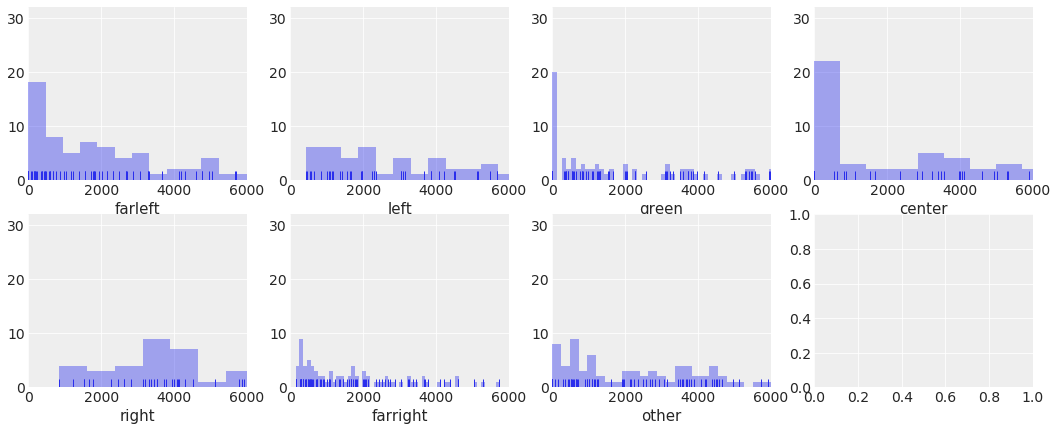

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. Now, how can we model this mixed process?

We're gonna run an intercept-only hierarchical softmax regression with simulated data, to see if this model indeed captures the structure of the data. If that's the case, we'll be able then to add predictors and a covariance structure between slopes and intercepts. First, let's define index variables:

In [220]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values  # for the real model

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

And now we simulate zero-inflated multinomial data. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts.

In [16]:
# -1.8 on logit scale is about 14% on p scale:
true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a)
true_sigma_pop = pm.Exponential.dist(1.0, shape=Nparties - 1).random()
print("true_sigma_district: ", true_sigma_pop)

true_a_district = pm.Normal.dist(
    true_a, true_sigma_pop, shape=(Ndistricts, Nparties - 1)
).random()
true_a_other = np.full(shape=(Ndistricts, 1), fill_value=-2.2)
true_a_district_f = np.hstack((true_a_district, true_a_other))

# preferences of each district:
true_p_district = softmax(true_a_district_f, axis=1)
print("true_p_district: ", true_p_district.shape)
# preferences of each district, for 4 elections:
true_lat_p = true_p_district[district_id]

# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.68264894 -1.6982959  -1.65640132 -1.92520283 -1.9327591  -1.73236346]
true_sigma_district:  [0.14737746 0.63963603 0.09857036 1.29205121 2.53774282 2.01455614]
true_p_district:  (20, 7)
sim_R:  (80, 7)


In [17]:
with pm.Model() as m_multi:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    sigma_pop = pm.Exponential("sigma_pop", 1.0, shape=Nparties - 1)

    a_district = pm.Normal("a_district", a, sigma_pop, shape=(Ndistricts, Nparties - 1))
    a_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    a_district_f = tt.horizontal_stack(a_district, a_pivot)

    p_district = pm.Deterministic("p_district", tt.nnet.softmax(a_district_f))
    lat_p = tt.nnet.softmax(a_district_f[district_id])

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_multi = pm.sample(
        2000, tune=3000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_multi = pm.trace_to_dataframe(trace_multi)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district, sigma_pop, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [01:54<00:00, 87.59draws/s]


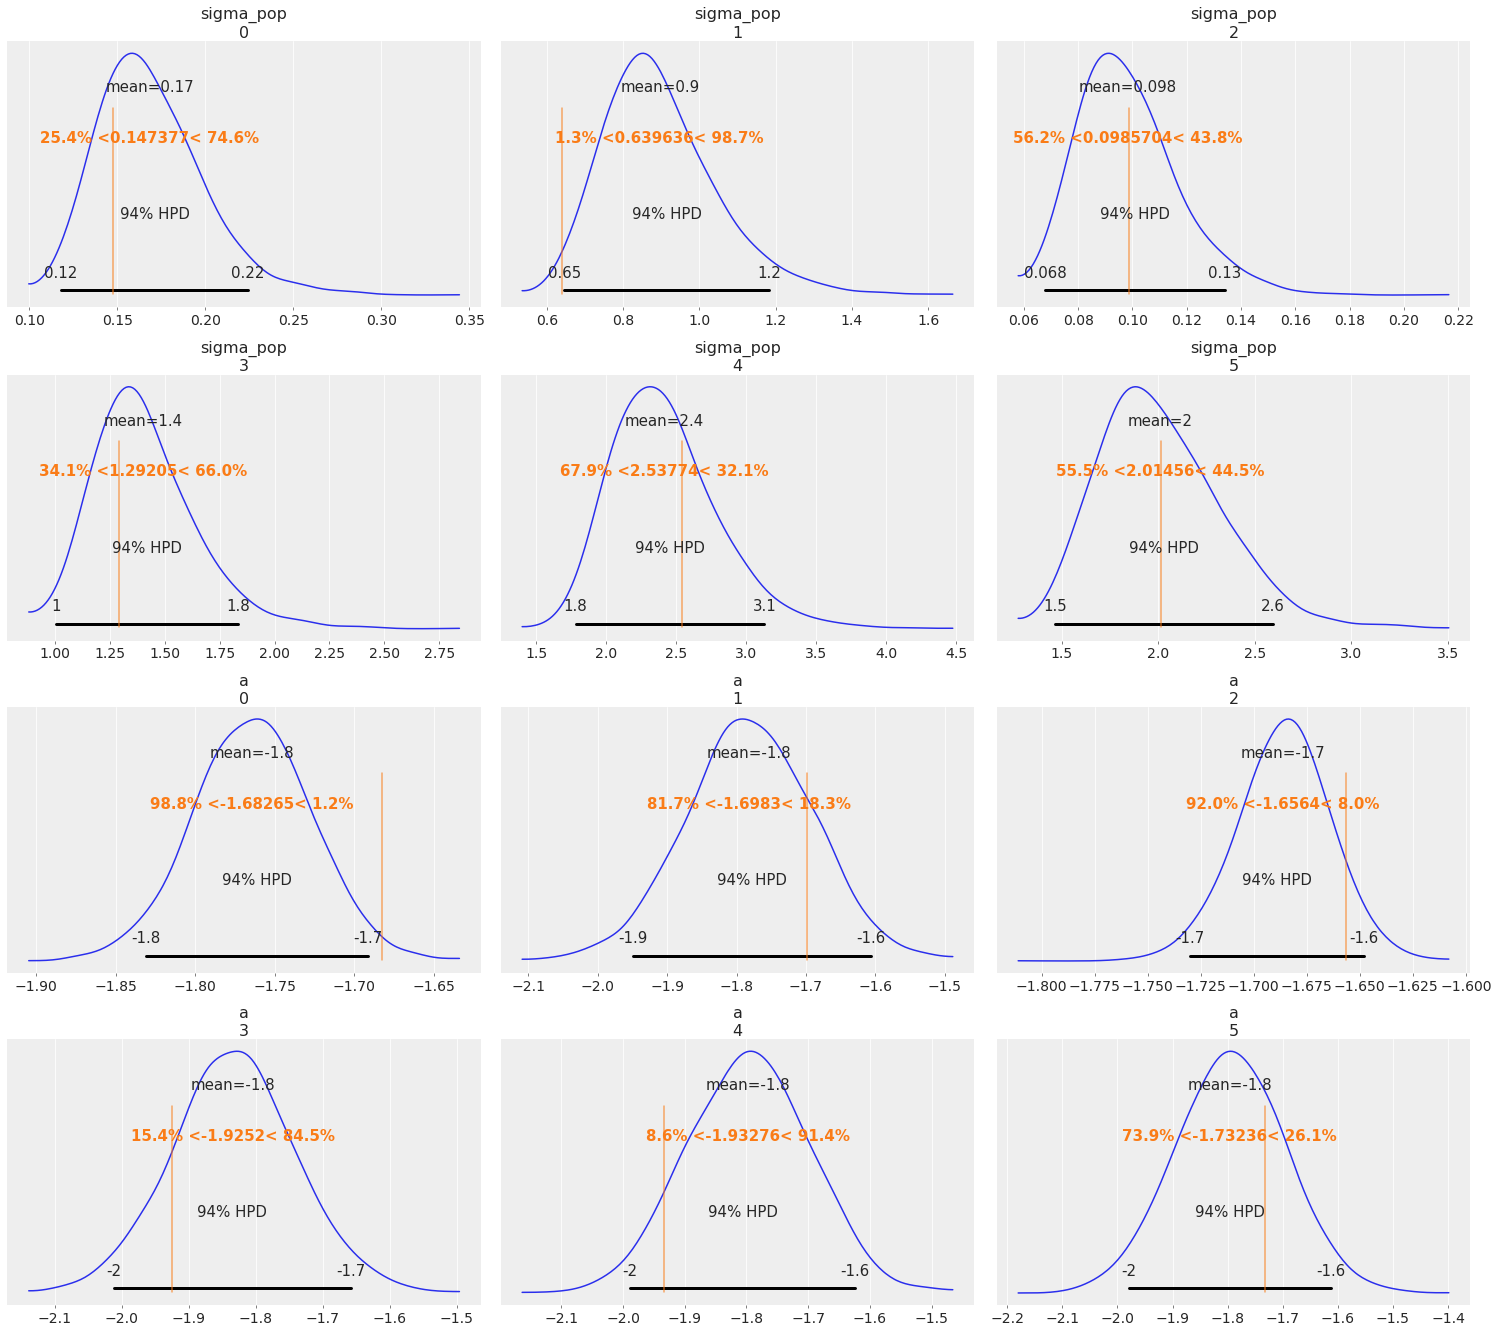

In [19]:
a_vals = [{"a_dim_0": i, "ref_val": true_a[i]} for i in range(len(true_a))]
s_vals = [
    {"sigma_pop_dim_0": i, "ref_val": true_sigma_pop[i]}
    for i in range(len(true_sigma_pop))
]

az.plot_posterior(
    trace_multi,
    var_names=["sigma_pop", "a"],
    ref_val={"sigma_pop": s_vals, "a": a_vals},
);

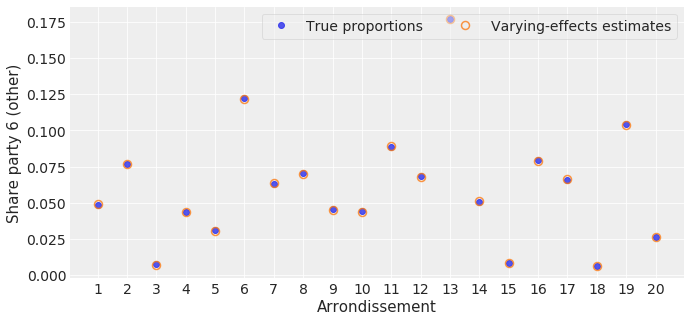

In [27]:
p_district_mean = mean_by_cluster("p_district", post_multi)
plot_compare_true(6, true_p_district, p_district_mean)

This model seems very good at recovering the structure in each district - even with the zero-inflation in some categories of the multinomial! If you changed the numpy random seed we set at the beginning of this notebook, your posterior distributions might look different. This is a good reminder that any particular sample may be misleading. The posterior distribution is not magic: it cannot necessarily recover the data-generating mechanism. And with real data, these models will never accurately recover the data-generating mechanism. At best, they describe it in a scientifically useful way. 

That being said, how does the model do when we add a predictor to the mix? To find out, we first have to add the predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [223]:
pred = pd.read_excel(
    "data/chomage-zone-demploi-2003-2019.xls", header=5, sheet_name="txcho_ze"
)
pred = pred[pred["LIBZE2010"] == "Paris"].iloc[:, 4:].T
pred.columns = ["unemployment"]

# as timestamps variables:
pred.index = pd.PeriodIndex(start=pred.index[0], periods=len(pred), freq="Q")
pred

,unemployment
2003Q1,8.4
2003Q2,8.7
2003Q3,8.6
2003Q4,9.0
2004Q1,9.2
...,...
2018Q1,7.9
2018Q2,7.8
2018Q3,7.8
2018Q4,7.4


In [224]:
# add quarters to original dataframe, to merge with predictor:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d = d.join(pred).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# standardize predictor:
d["unemployment"] = stdz(d["unemployment"])
d.head()

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type,unemployment
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale,-1.316346
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale,1.077010
2,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative,0.239336
3,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale,-1.316346
4,2014-03-25,Paris,2,6857,192,1565,2260,0,1663,272,905,municipale,1.077010


Now, we can simulate data. This is just an extension of what we did for the intercept-only model, only this time there is a standardized predictor that covaries with the intercepts:

In [120]:
# average baseline support:
true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a.round(2))
# average effect of unemployment:
true_b = pm.Normal.dist(-0.5, 0.2, shape=Nparties - 1).random()
print("true_b: ", true_b.round(2))
# std dev in intercepts:
true_sd_a = pm.Exponential.dist(1.0, shape=Nparties - 1).random()
print("true_sd_a: ", true_sd_a.round(2))
# std dev in slopes
true_sd_b = pm.Exponential.dist(0.5, shape=Nparties - 1).random()
print("true_sd_b: ", true_sd_b.round(2))
# correlation between intercepts and slopes:
rho = [0.4, -0.4, 0.1, 0.3, -0.5, 0.7]

# One mean vector of a and b for each party:
Mu = np.array([true_a, true_b]).T
cov_ab = true_sd_a * true_sd_b * rho
# One cov matrix of a and b for each party:
Sigma = np.array([[true_sd_a ** 2, cov_ab], [cov_ab, true_sd_b ** 2]]).transpose(
    2, 1, 0
)

# simulate observations:
vary_effects = []
for p in range(Nparties - 1):
    vary_effects.append(
        np.random.multivariate_normal(mean=Mu[p], cov=Sigma[p], size=Ndistricts)
    )
vary_effects = np.array(vary_effects)
print("vary_effects: ", vary_effects.shape)

# linear model:
mu = (
    vary_effects[:, district_id, 0]
    + vary_effects[:, district_id, 1] * d.unemployment.values
).T
# append last category:
vary_other = np.full(shape=(Ndistricts, 1), fill_value=-2.2)
mu = np.hstack((mu, vary_other[district_id]))
print("mu: ", mu.shape)

# preferences of each district, for 4 elections:
true_lat_p = softmax(mu, axis=1)
# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.68264894 -1.6982959  -1.65640132 -1.92520283 -1.9327591  -1.73236346]
true_b:  [-0.51701621 -0.7247219  -0.44729291 -0.59501408 -0.79241305 -0.6135789 ]
true_sd_a:  [0.99397335 0.07566925 0.79828734 2.41170281 0.92306355 0.7460525 ]
true_sd_b:  [0.97807971 1.14979795 0.27008669 0.78082693 1.05702249 1.09644067]
vary_effects:  (6, 20, 2)
mu:  (80, 7)
sim_R:  (80, 7)


In [121]:
# centered:
with pm.Model() as m_slope:
    mus_parties = []
    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=2, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(2, k=1)])

        # average itc and slope for each party:
        ab = pm.Normal(
            f"ab_p{p}", mu=np.array([-1.8, -0.5]), sd=np.array([0.1, 0.2]), shape=2
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 2)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * d.unemployment.values
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_slope = pm.sample(
        2000, tune=3000, cores=4, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

with open("trace_slope.pkl", "wb") as f:
    pickle.dump({"model": m_slope, "trace": trace_slope}, f)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [34:33<00:00,  4.82draws/s]


In [122]:
az.summary(
    trace_slope,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab_p0[0],-1.71,0.09,-1.88,-1.53,0.00,0.0,5446.59,5392.88,5483.20,2774.40,1.0
ab_p0[1],-0.31,0.17,-0.64,-0.01,0.00,0.0,5381.29,3893.78,5445.49,2619.91,1.0
ab_p1[0],-1.70,0.02,-1.73,-1.67,0.00,0.0,5150.74,5150.74,5162.86,3268.72,1.0
ab_p1[1],-0.59,0.16,-0.87,-0.29,0.00,0.0,4902.06,4308.75,4922.18,2502.12,1.0
ab_p2[0],-1.80,0.08,-1.97,-1.65,0.00,0.0,6023.68,6019.21,6015.15,2932.09,1.0
ab_p2[1],-0.49,0.07,-0.62,-0.34,0.00,0.0,5164.44,4852.15,5171.87,2525.45,1.0
ab_p3[0],-1.83,0.09,-2.02,-1.66,0.00,0.0,5590.07,5561.29,5594.51,2769.55,1.0
ab_p3[1],-0.73,0.13,-0.96,-0.48,0.00,0.0,5285.88,5285.88,5359.82,2877.73,1.0
ab_p4[0],-1.83,0.09,-2.00,-1.66,0.00,0.0,5750.06,5722.98,5762.32,3024.26,1.0
ab_p4[1],-0.66,0.13,-0.90,-0.40,0.00,0.0,5435.87,5302.56,5429.67,3178.54,1.0


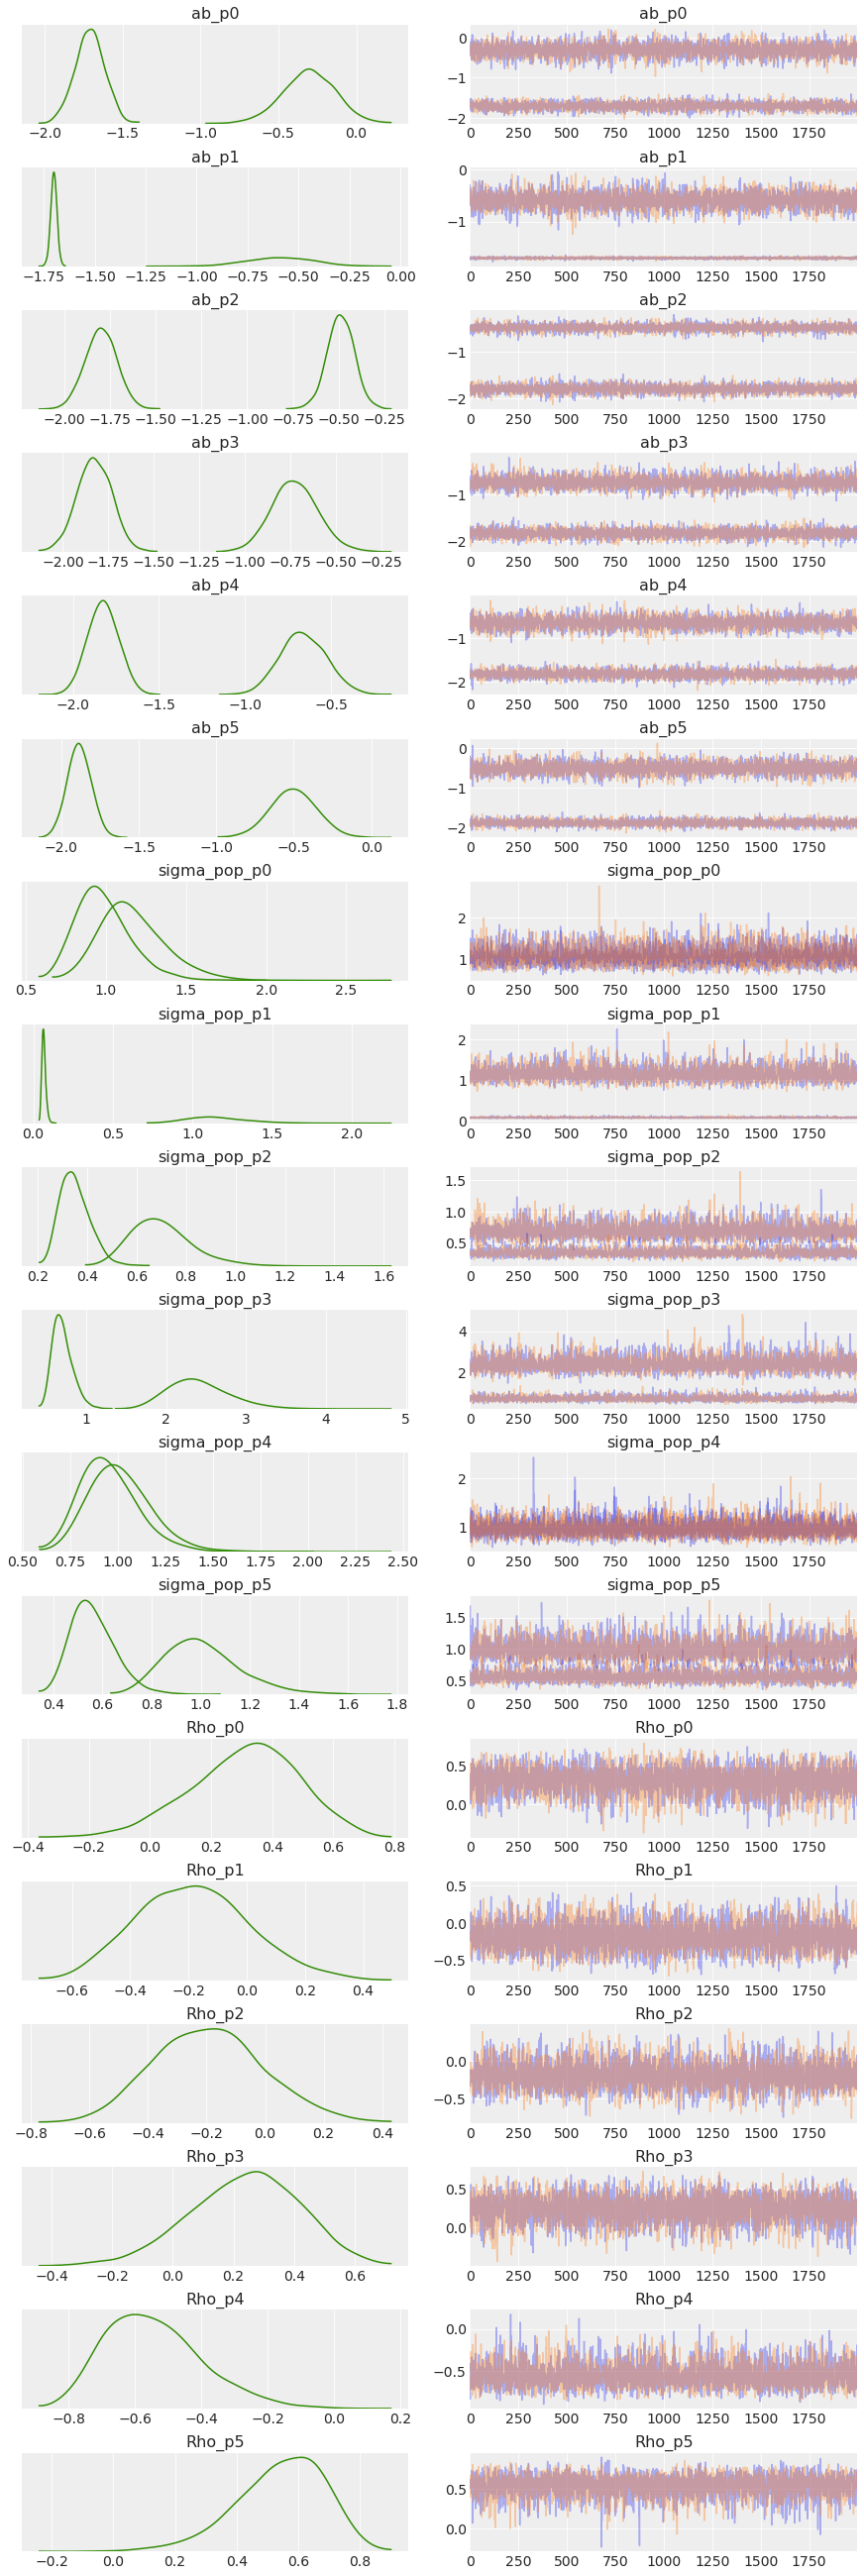

In [124]:
az.plot_trace(
    trace_slope,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    compact=True,
    combined=True,
)

In [15]:
with open("trace_slope.pkl", "rb") as f:
    data = pickle.load(f)
m_slope, trace_slope = data["model"], data["trace"]
post_slope = pm.trace_to_dataframe(trace_slope)

Does the model recover the variation in intercepts (0) and slopes (1) by party across districts?

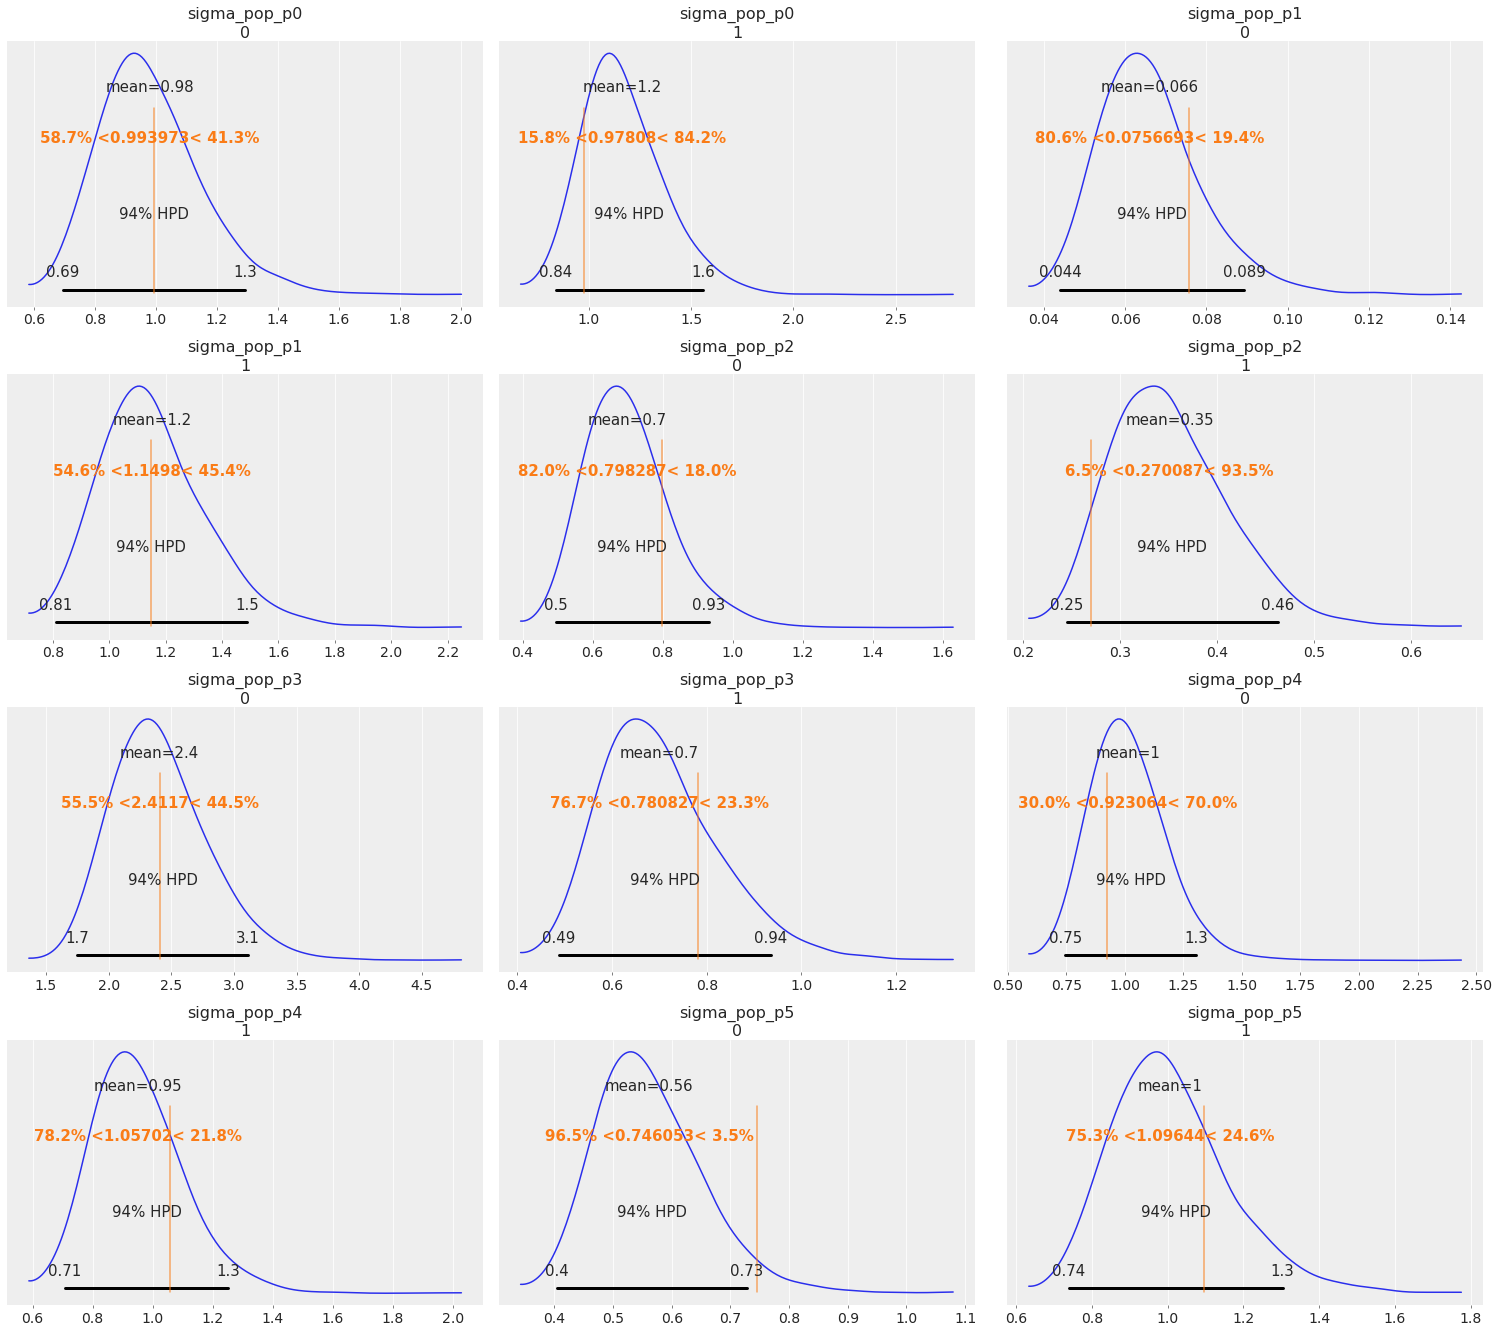

In [128]:
s_vals = {f"sigma_pop_p{p}": [] for p in range(len(true_sd_a))}

for i in range(len(true_sd_a)):
    s_vals[f"sigma_pop_p{i}"].append(
        {f"sigma_pop_p{i}_dim_0": 0, "ref_val": true_sd_a[i]}
    )
    s_vals[f"sigma_pop_p{i}"].append(
        {f"sigma_pop_p{i}_dim_0": 1, "ref_val": true_sd_b[i]}
    )

az.plot_posterior(trace_slope, var_names=list(s_vals.keys()), ref_val=s_vals)

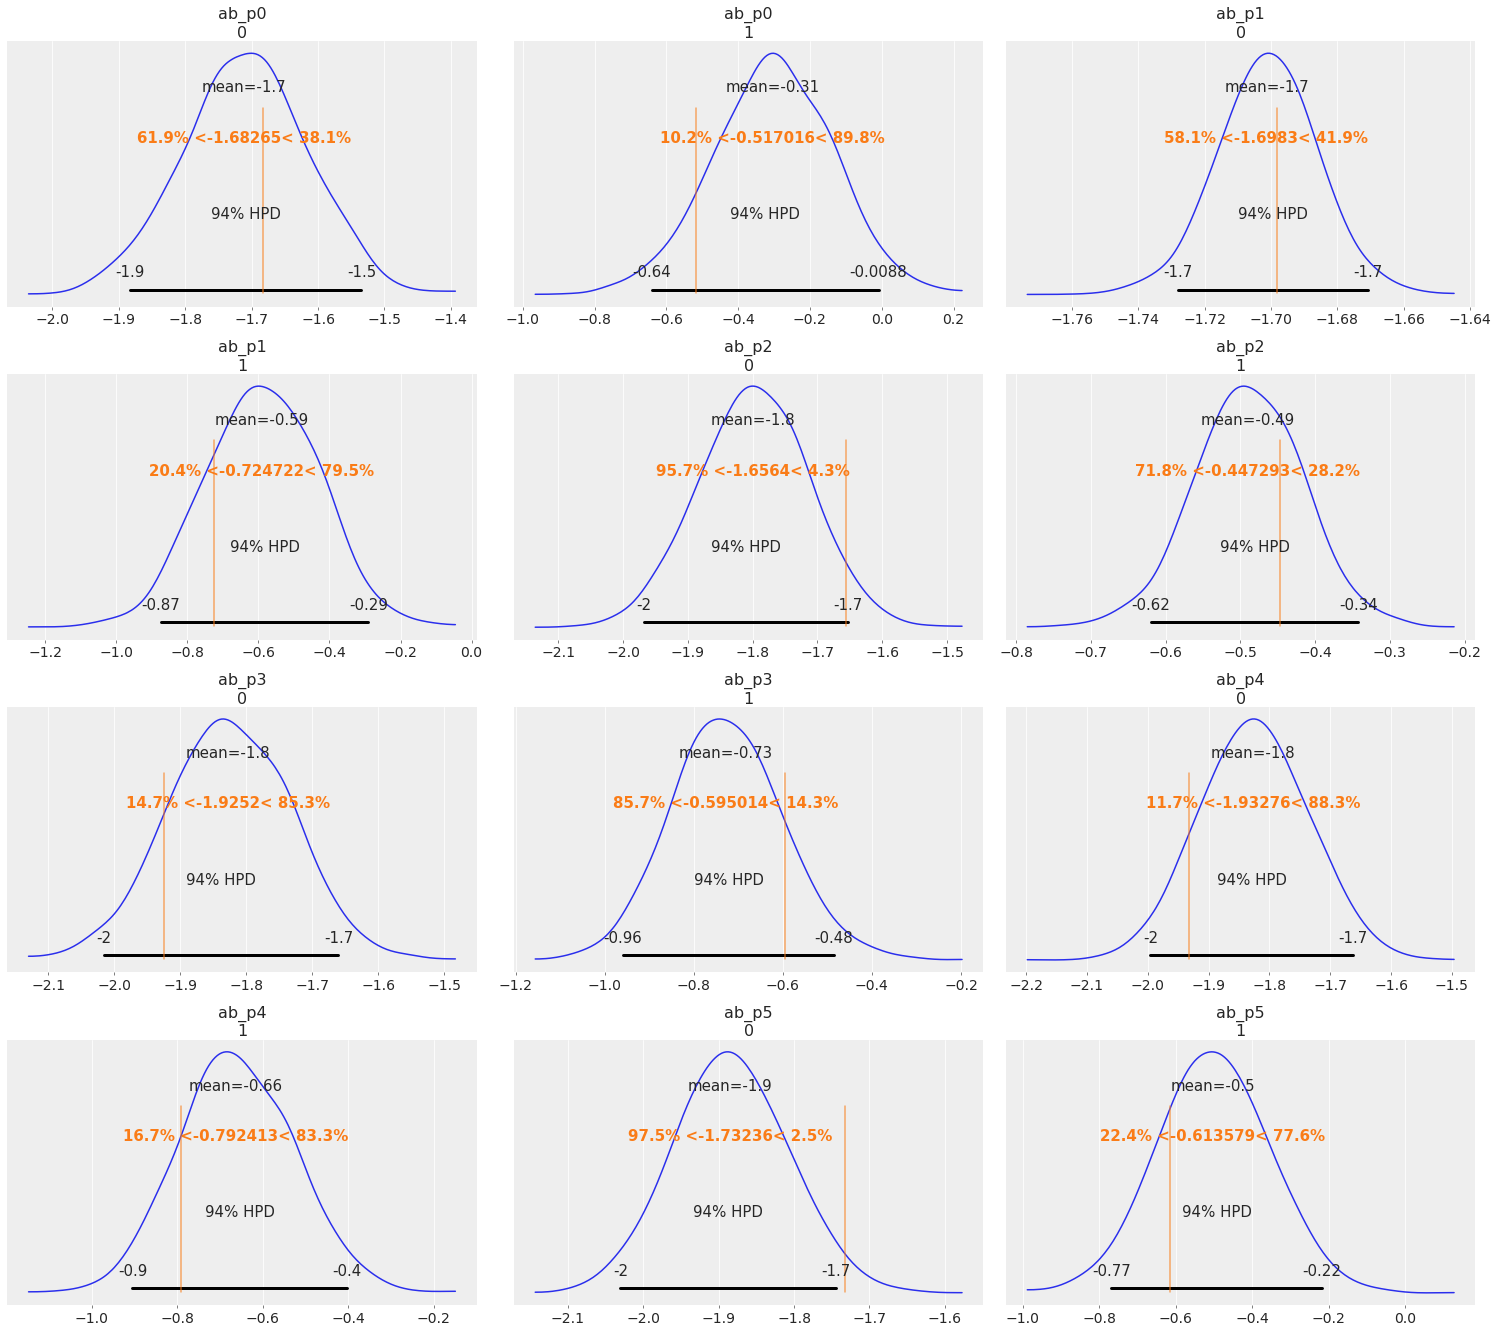

In [126]:
# average itc and slope for each party:
a_vals = {f"ab_p{p}": [] for p in range(len(true_a))}

for i in range(len(true_a)):
    a_vals[f"ab_p{i}"].append({f"ab_p{i}_dim_0": 0, "ref_val": true_a[i]})
    a_vals[f"ab_p{i}"].append({f"ab_p{i}_dim_0": 1, "ref_val": true_b[i]})

az.plot_posterior(trace_slope, var_names=list(a_vals.keys()), ref_val=a_vals)

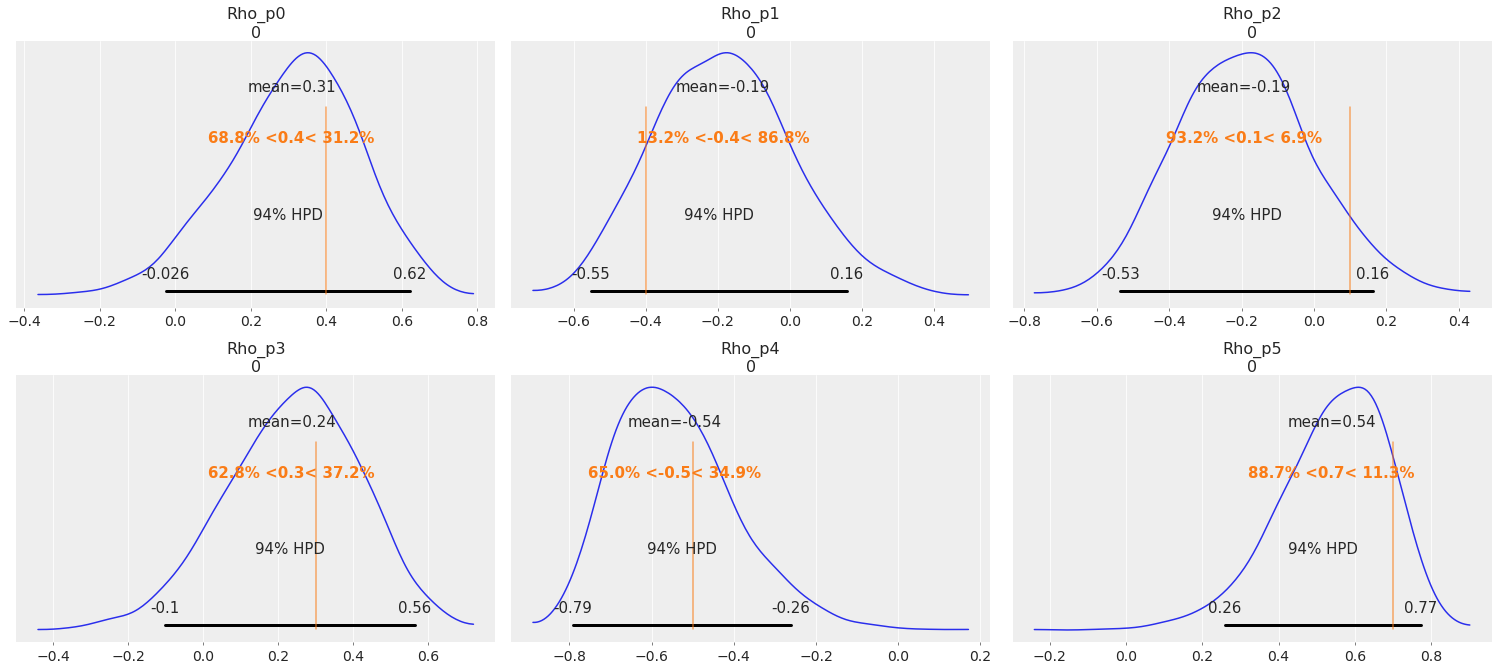

In [127]:
# correlation between intercepts and slopes, for each party:
r_vals = {f"Rho_p{p}": [] for p in range(len(rho))}

for i in range(len(rho)):
    r_vals[f"Rho_p{i}"].append({"ref_val": rho[i]})

az.plot_posterior(trace_slope, var_names=list(r_vals.keys()), ref_val=r_vals)

It seems like the model does pretty well at recovering the true parameters of the population. Let's check if it does so at a lower level -- can it recover the true intercepts, slopes and, most importantly, the true party-proportions at the district level?

In [141]:
true_a_district, true_b_district = vary_effects[:, :, 0].T, vary_effects[:, :, 1].T

post_slope = pm.trace_to_dataframe(trace_slope)
vary_effects_est = post_slope.filter(like="ab_district_p")
a_district_est = vary_effects_est.loc[:, vary_effects_est.columns.str.endswith("0")]
b_district_est = vary_effects_est.loc[:, vary_effects_est.columns.str.endswith("1")]

In [142]:
a_district_est_mean = pd.DataFrame(index=range(Nparties - 1), columns=range(Ndistricts))
a_district_est_mean.index.name = "Party"
a_district_est_mean.columns.name = "Arrondissement"

for i in range(Ndistricts):
    a_district_est_mean[i] = (
        a_district_est[
            [
                f"ab_district_p0__{i}_0",
                f"ab_district_p1__{i}_0",
                f"ab_district_p2__{i}_0",
                f"ab_district_p3__{i}_0",
                f"ab_district_p4__{i}_0",
                f"ab_district_p5__{i}_0",
            ]
        ]
        .mean()
        .values
    )
a_district_est_mean = a_district_est_mean.T

b_district_est_mean = pd.DataFrame(index=range(Nparties - 1), columns=range(Ndistricts))
b_district_est_mean.index.name = "Party"
b_district_est_mean.columns.name = "Arrondissement"

for i in range(Ndistricts):
    b_district_est_mean[i] = (
        b_district_est[
            [
                f"ab_district_p0__{i}_1",
                f"ab_district_p1__{i}_1",
                f"ab_district_p2__{i}_1",
                f"ab_district_p3__{i}_1",
                f"ab_district_p4__{i}_1",
                f"ab_district_p5__{i}_1",
            ]
        ]
        .mean()
        .values
    )
b_district_est_mean = b_district_est_mean.T

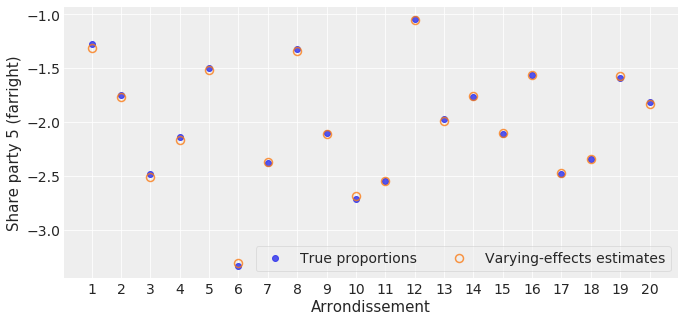

In [148]:
plot_compare_true(5, true_a_district, a_district_est_mean)

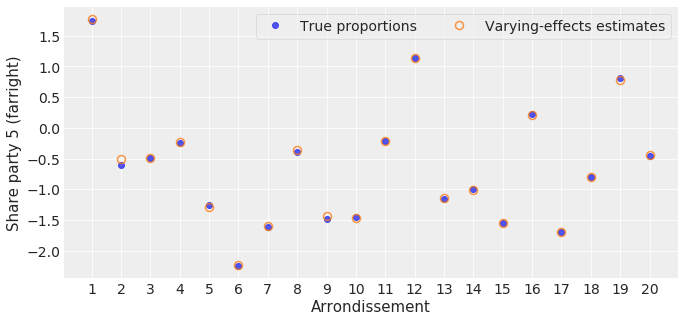

In [154]:
plot_compare_true(5, true_b_district, b_district_est_mean)

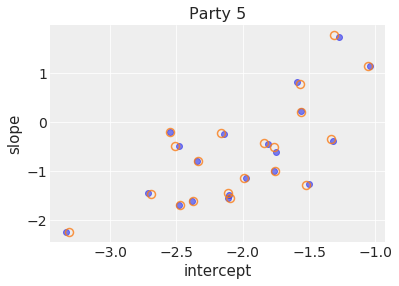

In [161]:
party_id = 5
plt.figure(figsize=(6, 4))

plt.plot(
    pd.DataFrame(true_a_district)[party_id],
    pd.DataFrame(true_b_district)[party_id],
    "o",
    ms=6,
    alpha=0.6,
    label="True parameters",
)
plt.plot(
    a_district_est_mean[party_id],
    b_district_est_mean[party_id],
    "o",
    fillstyle="none",
    ms=8,
    markeredgewidth=1.5,
    alpha=0.8,
    label="Varying-effects means",
)

plt.xlabel("intercept")
plt.ylabel("slope")
plt.title(f"Party {party_id}")

In [177]:
# outcome space:
lat_p_est = pd.DataFrame(trace_slope["lat_p"].mean(0))
lat_p_est["date"] = d.date.values
lat_p_est["arrondissement"] = d.arrondissement.values
lat_p_est["umeployment"] = d.unemployment.values
lat_p_est.head()

,0,1,2,3,4,5,6,date,arrondissement,umeployment
0,0.219816,0.043338,0.609035,0.027537,0.029968,0.009024,0.061282,2008-05-23,1,-1.580969
1,0.131910,0.103369,0.060901,0.005965,0.021531,0.643188,0.033137,2014-03-25,1,1.168542
2,0.267292,0.129175,0.231046,0.017227,0.040920,0.244735,0.069605,2017-04-23,1,0.206213
3,0.267292,0.129175,0.231046,0.017227,0.040920,0.244735,0.069605,2017-06-11,1,0.206213
4,0.000306,0.273285,0.039260,0.002079,0.670406,0.011354,0.003310,2008-05-23,2,-1.580969


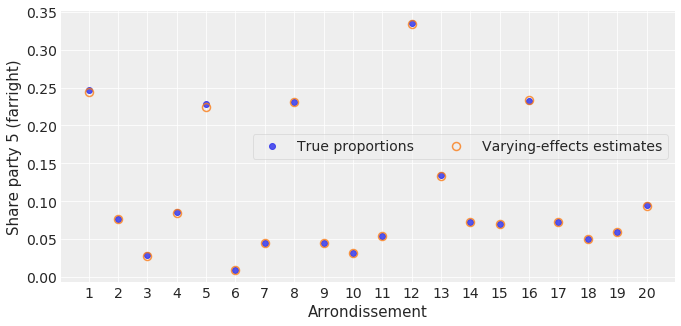

In [209]:
plot_compare_true(
    5,
    true_lat_p[lat_p_est.date == "2017-06-11"],
    lat_p_est[lat_p_est.date == "2017-06-11"],
)

And indeed, the model recovers very closely the true proportions by district, for each of the 4 elections we tested -- I think we deserve a beer.

Now let's look at shrinkage (or pooling of information), by comparing the previous varying estimates to unpooled estimates. We need to run a model first:

In [210]:
with pm.Model() as m_unpooled:
    a_district = pm.Normal("a_district", -1.8, 0.1, shape=(Ndistricts, Nparties - 1))
    b_district = pm.Normal("b_district", -0.5, 0.2, shape=(Ndistricts, Nparties - 1))

    # linear model:
    mu = (
        a_district[district_id]
        + b_district[district_id] * d.unemployment.values[:, None]
    )

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mu = tt.horizontal_stack(mu, vary_pivot[district_id])

    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mu))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_unpooled = pm.sample(
        2000, tune=3000, cores=4, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_unpooled = pm.trace_to_dataframe(trace_unpooled)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b_district, a_district]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [04:16<00:00, 39.05draws/s]


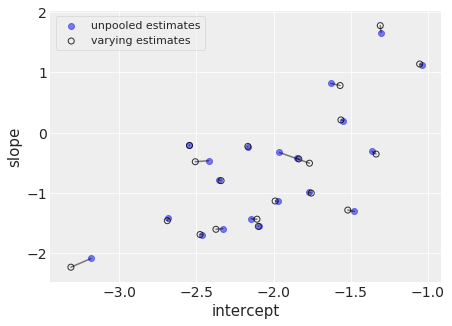

In [228]:
party_id = 5

# unpooled estimates:
a1 = trace_unpooled["a_district"][:, :, party_id].mean(0)
b1 = trace_unpooled["b_district"][:, :, party_id].mean(0)

# partially pooled estimates:
a2b2 = trace_slope[f"ab_district_p{party_id}"].mean(0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(a1, b1, label="unpooled estimates", alpha=0.6)
ax.scatter(
    a2,
    b2,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="varying estimates",
    alpha=0.8,
)

ax.plot([a1, a2], [b1, b2], "k-", alpha=0.5)
ax.set_xlabel("intercept")
ax.set_ylabel("slope")
ax.legend(frameon=True, framealpha=0.5, fontsize=11);

In these plots, we can see that the varying-effects model shrinks the estimates towards the center of the two-dimensional MvNormal distribution of intercepts and slopes -- and it does so for each of the 6 parties. We could see this pooling of information even better if we drew ellipses for the 2D MvNormal, but we'll do that only for the model that ran on observed data, not fake data.

Now, what about a model that doesn't take into account the covariance between slopes and intercepts. Does it change inference much? Let's run it and see!

In [229]:
with pm.Model() as m_nocov:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    b = pm.Normal("b", -0.5, 0.2, shape=Nparties - 1)
    sigma_a = pm.Exponential("sigma_a", 1.0, shape=Nparties - 1)
    sigma_b = pm.Exponential("sigma_b", 1.0, shape=Nparties - 1)

    a_district = pm.Normal("a_district", a, sigma_a, shape=(Ndistricts, Nparties - 1))
    b_district = pm.Normal("b_district", b, sigma_b, shape=(Ndistricts, Nparties - 1))

    # linear model:
    mu = (
        a_district[district_id]
        + b_district[district_id] * d.unemployment.values[:, None]
    )

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mu = tt.horizontal_stack(mu, vary_pivot[district_id])

    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mu))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_nocov = pm.sample(
        2000, tune=3000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_nocov = pm.trace_to_dataframe(trace_nocov)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_district, a_district, sigma_b, sigma_a, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [04:28<00:00, 37.20draws/s]


In [237]:
az.summary(
    trace_slope,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
    ],
    round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab_p0[0],-1.71,0.09,-1.88,-1.53,0.00,0.0,5446.59,5392.88,5483.20,2774.40,1.0
ab_p0[1],-0.31,0.17,-0.64,-0.01,0.00,0.0,5381.29,3893.78,5445.49,2619.91,1.0
ab_p1[0],-1.70,0.02,-1.73,-1.67,0.00,0.0,5150.74,5150.74,5162.86,3268.72,1.0
ab_p1[1],-0.59,0.16,-0.87,-0.29,0.00,0.0,4902.06,4308.75,4922.18,2502.12,1.0
ab_p2[0],-1.80,0.08,-1.97,-1.65,0.00,0.0,6023.68,6019.21,6015.15,2932.09,1.0
ab_p2[1],-0.49,0.07,-0.62,-0.34,0.00,0.0,5164.44,4852.15,5171.87,2525.45,1.0
ab_p3[0],-1.83,0.09,-2.02,-1.66,0.00,0.0,5590.07,5561.29,5594.51,2769.55,1.0
ab_p3[1],-0.73,0.13,-0.96,-0.48,0.00,0.0,5285.88,5285.88,5359.82,2877.73,1.0
ab_p4[0],-1.83,0.09,-2.00,-1.66,0.00,0.0,5750.06,5722.98,5762.32,3024.26,1.0
ab_p4[1],-0.66,0.13,-0.90,-0.40,0.00,0.0,5435.87,5302.56,5429.67,3178.54,1.0


In [238]:
az.summary(trace_nocov, var_names=["a", "b", "sigma_a", "sigma_b"], round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.70,0.10,-1.88,-1.52,0.00,0.0,4930.13,4930.13,4902.14,2694.76,1.0
a[1],-1.70,0.01,-1.73,-1.67,0.00,0.0,5371.57,5369.38,5386.75,3115.97,1.0
a[2],-1.80,0.09,-1.96,-1.64,0.00,0.0,4719.94,4653.19,4613.31,2076.50,1.0
a[3],-1.83,0.10,-2.02,-1.64,0.00,0.0,5416.40,5381.29,5397.62,2743.52,1.0
a[4],-1.81,0.09,-1.97,-1.64,0.00,0.0,5239.03,5213.98,5242.55,2523.21,1.0
a[5],-1.88,0.08,-2.03,-1.74,0.00,0.0,5244.28,5244.28,5252.29,2432.19,1.0
b[0],-0.25,0.17,-0.54,0.08,0.00,0.0,5969.47,4032.47,5996.60,3207.17,1.0
b[1],-0.59,0.16,-0.89,-0.28,0.00,0.0,5320.39,5156.12,5329.44,2491.83,1.0
b[2],-0.49,0.07,-0.62,-0.36,0.00,0.0,4805.87,4526.83,4827.10,2645.56,1.0
b[3],-0.76,0.13,-0.99,-0.53,0.00,0.0,4914.30,4914.30,5026.06,2986.77,1.0


So the posterior distributions of the average effects ($\alpha$ and $\beta$) and the standard deviation parameters are essentially identical. Assuming no correlation didn’t completely change inference. We're primarily interested in differences in the varying effects estimates. So, when we'll deal with real data, we'll plot them together and see if there are any differences (in posterior means). But you can already keep in mind that the model that includes the covariances will be, on average, more accurate -- it exploits additional information about the population in order to shrink in both dimensions.

Ok, we've done *a lot* of tests. We now that both our intercept-only and varying-effects models run (more or less) smoothly on simulated data. Now it's time to dive and run the varying-effects model on real data!

In [225]:
with pm.Model() as m_real:
    mus_parties = []
    unemp = pm.Data("unemp", d.unemployment.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=2, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(2, k=1)])

        # average itc and slope for each party:
        ab = pm.Normal(
            f"ab_p{p}", mu=np.array([-1.8, 0.0]), sd=np.array([0.1, 0.5]), shape=2
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 2)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0] + ab_district[district_id, 1] * unemp
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

# with open("trace_real.pkl", "wb") as f:
#    pickle.dump({"model": m_real, "trace": trace_real}, f)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 6 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
INFO:pymc3:NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [06:37<00:00, 20.10draws/s] 


In [7]:
with open("trace_real2.pkl", "rb") as f:
    data = pickle.load(f)
m_real, trace_real = data["model"], data["trace"]
post_real = pm.trace_to_dataframe(trace_real)

In [226]:
az.summary(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab_p0[0],-1.96,0.09,-2.13,-1.80,0.00,0.0,2873.50,2873.50,2872.78,1680.04,1.00
ab_p0[1],-0.31,0.16,-0.61,0.00,0.00,0.0,2425.38,2425.38,2432.96,1629.73,1.00
ab_p1[0],-1.68,0.10,-1.86,-1.50,0.00,0.0,3086.35,3056.47,3095.91,1664.45,1.00
ab_p1[1],-0.39,0.08,-0.54,-0.22,0.00,0.0,2526.07,2424.73,2541.98,1467.06,1.00
ab_p2[0],-1.87,0.10,-2.06,-1.70,0.00,0.0,2429.53,2417.66,2426.56,1544.39,1.00
ab_p2[1],-0.26,0.07,-0.40,-0.13,0.00,0.0,2622.41,2438.18,2645.36,1302.50,1.00
ab_p3[0],-1.69,0.10,-1.88,-1.50,0.00,0.0,3090.38,3061.71,3072.41,1682.72,1.00
ab_p3[1],0.80,0.15,0.51,1.07,0.00,0.0,1980.89,1980.89,2152.32,1151.35,1.00
ab_p4[0],-1.66,0.10,-1.83,-1.46,0.00,0.0,2777.83,2762.56,2786.24,1632.44,1.00
ab_p4[1],-0.12,0.10,-0.30,0.09,0.00,0.0,2083.63,1605.51,2032.37,1511.28,1.00


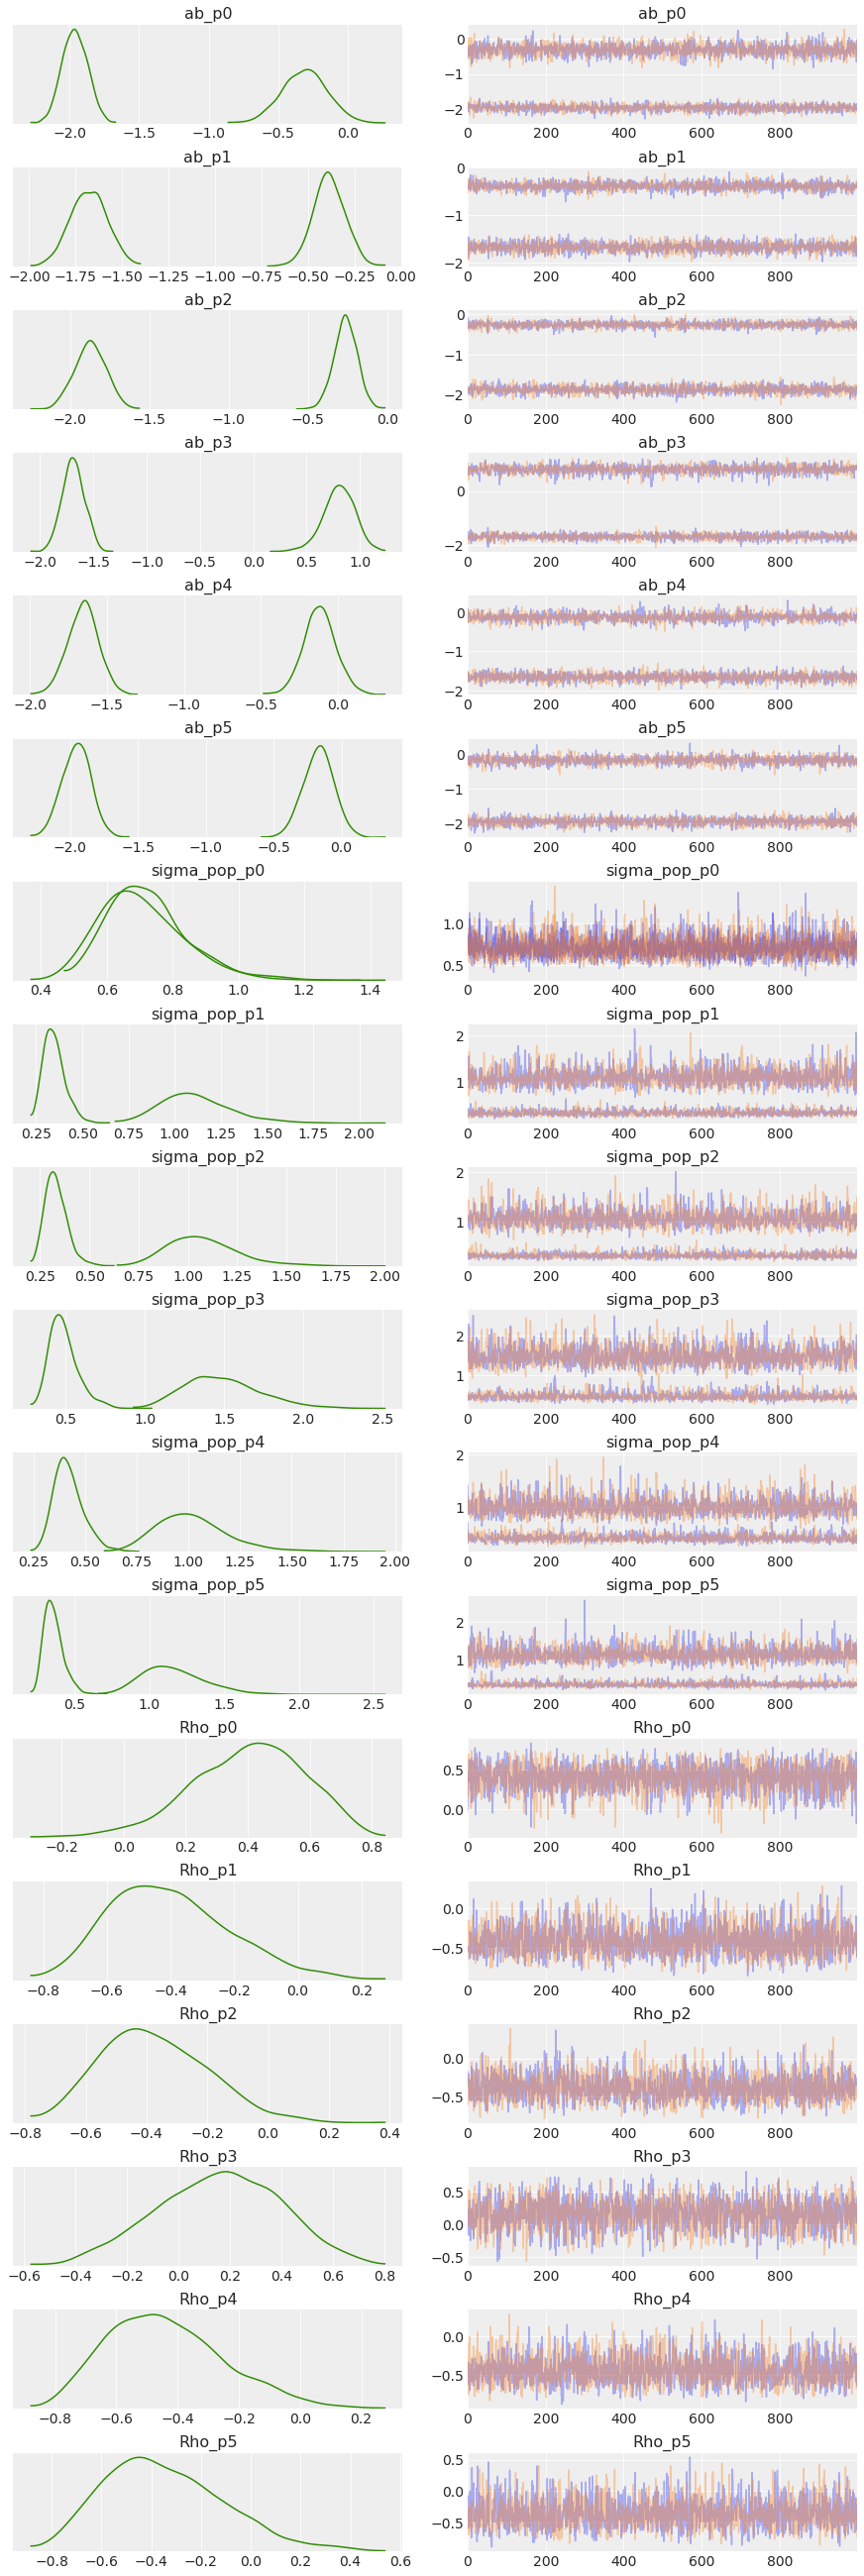

In [227]:
az.plot_trace(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    compact=True,
    combined=True,
)

Everything looks fine. Now let's tackle posterior predictive checks! We'll draw two types of PPC here, starting by what Richard McElreath calls "**counterfactual plots**". These show how predictions change when the one predictor in our model varies, even when this predictor takes unreal values -- hence "counterfactual". 

So, we are going to sample posterior predictive probabilities from the model, with new `unemployment` values. This means we get 4000 samples for each party's probability, in each district, under the new counterfactual conditions. The plots then display the change in probability across values of the predictor of interest and... tadaaaa!

In [228]:
# counterfactuals for a given district:
d_id = np.random.randint(0, Ndistricts)
predictor_seq = np.linspace(-3, 4)
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, d_id, 0]
            + trace_real[f"ab_district_p{p}"][:, d_id, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000)

In [229]:
# append last category:
mus_other = np.full(shape=(1, mus_pp.shape[1], mus_pp.shape[2]), fill_value=-2.2)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000)

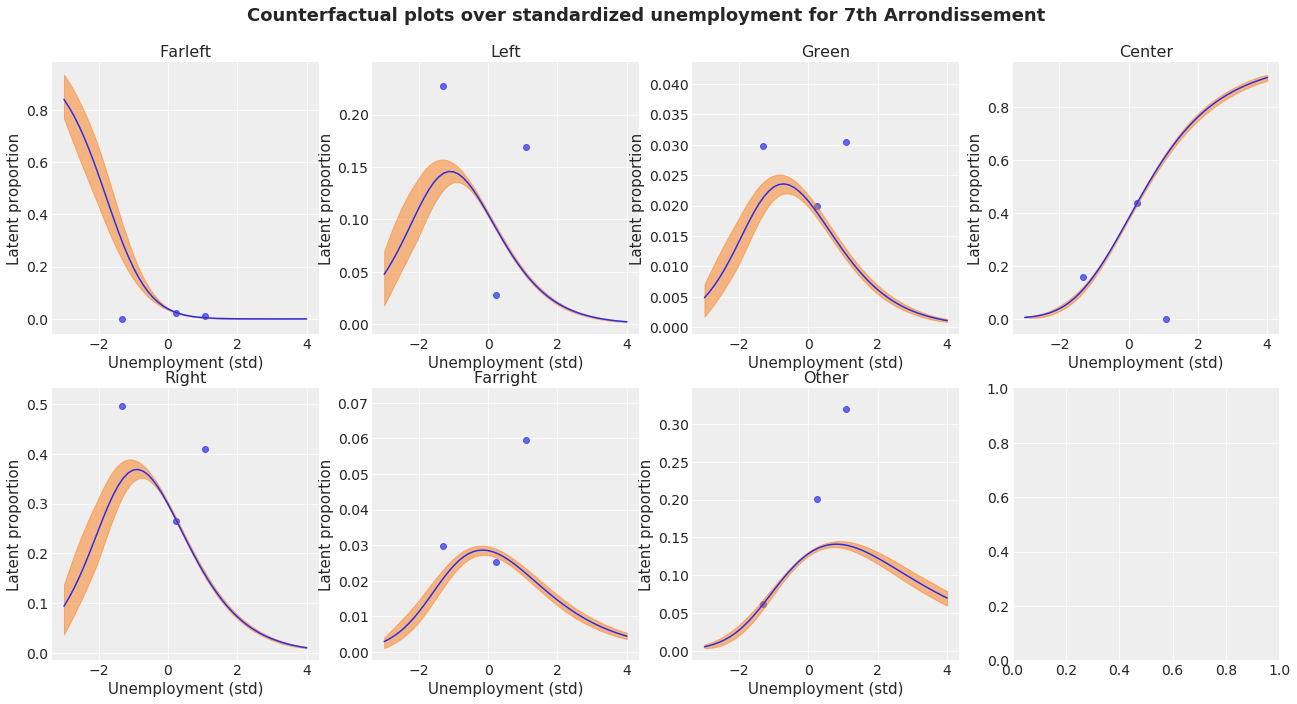

In [230]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            col.scatter(
                d.loc[d.arrondissement == d_id + 1, "unemployment"],
                d.loc[d.arrondissement == d_id + 1, f"{PARTIES[i]}"]
                / d.loc[d.arrondissement == d_id + 1, "N"],
                alpha=0.7,
            )
            col.plot(predictor_seq, prob_mean[i, :])
            az.plot_hpd(predictor_seq, prob_pp[i, :, :].T, ax=col)
            col.set_xlabel("Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Counterfactual plots over standardized unemployment for {d_id + 1}th Arrondissement",
    y=0.95,
    size=18,
    weight="bold",
)

In [231]:
# counterfactuals for all districts:
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, :, 0]
            + trace_real[f"ab_district_p{p}"][:, :, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000, 20)

In [232]:
# append last category:
mus_other = np.full(
    shape=(1, mus_pp.shape[1], mus_pp.shape[2], mus_pp.shape[3]), fill_value=-2.2
)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000, 20)

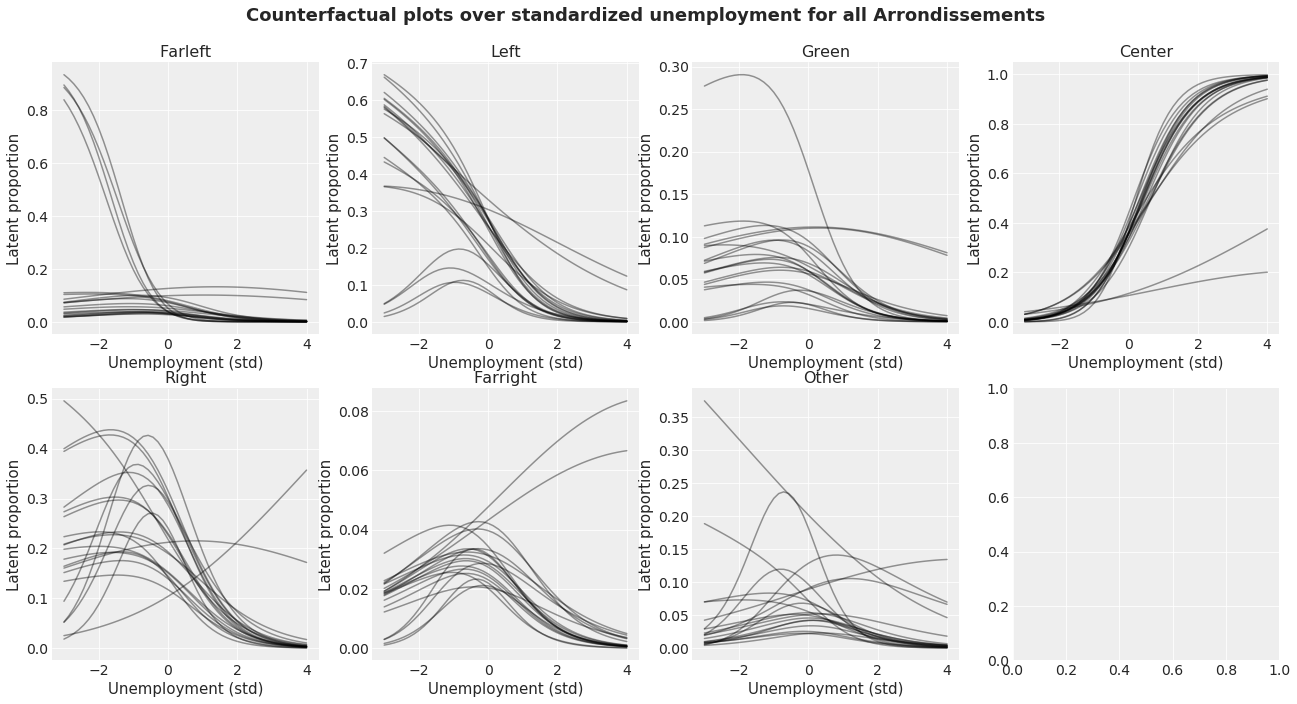

In [233]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            for dis in range(Ndistricts):
                col.plot(predictor_seq, prob_mean[i, :, dis], "k", alpha=0.4)
            col.set_xlabel("Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    "Counterfactual plots over standardized unemployment for all Arrondissements",
    y=0.95,
    size=18,
    weight="bold",
)

These plots help us understand the model's implications. As seen in the summary table, the only reliably positive slope is for the centrist party, while the only reliably negative one is for the far left party. This means that when unemployment increases, so does the centrist party's share, on average, while the farl left's decreases. For other parties, the effect of unemployment seems more ambiguous, helping then hurting them when unemployment reaches 0 (its mean value). 

Don't forget however that these effects are contingent on the district we're looking at -- some districts may react more to unemployment than others -- and, as slopes and intercepts are correlated, the variation is multi-dimensional -- yeah, it's a complicated model and the best way to understand it is to plot what it's telling us on the outcome space, as we did here.

Keep in mind though that these predictons are *counterfactual*: they display predictions for sometimes impossible values of the predictor - unrealistically high or low unemployment rates. Also, here we show the raw, observed proportions for each party, but the lines depict the *latent* probabilities -- which we don't get to observe. So, if the fit is not perfect, it's because it's normal. First, the model is trying to infer the latent probabilities from the observed, zero-inflated proportions, which inevitably leads to differences. Second, we should't expect perfect fit in-sample, because the model pools information among intercepts and slopes -- which reduces in-sample fit to improve out-of-sample predictions.

However, it's interesting to compare the model's predictions against raw data. Let's do that, now that we have a better understanding of the posterior distribution. The idea is to plot predictions against observed data, to see if the model correctly approximates the posterior distribution, and where the model fails. That's what the appropriately named "**posterior predictive plots**" do.

Before that though, let's compute what percentage of predictions we got right, to get a sense of how the model's predictions fit the raw data:

In [234]:
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type,unemployment
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale,-1.316346
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale,1.077010
2,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative,0.239336
3,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale,-1.316346
4,2014-03-25,Paris,2,6857,192,1565,2260,0,1663,272,905,municipale,1.077010
5,2017-06-11,Paris,2,7560,601,563,810,4004,843,147,592,legislative,0.239336
6,2008-05-23,Paris,3,11974,225,6685,1237,1111,2458,258,0,municipale,-1.316346
7,2014-03-25,Paris,3,11615,464,5493,1252,0,3379,580,447,municipale,1.077010
8,2017-06-11,Paris,3,13014,1035,1637,1299,6513,1231,340,959,legislative,0.239336
9,2008-05-23,Paris,4,10573,151,5127,834,863,3312,286,0,municipale,-1.316346


In [235]:
# PPC, euro2019: intcpt-only, new clusters (type elec, date elec), new preds, add elections
# shrinkage, nocov
share_est = parties_available * trace_real["lat_p"]
share_est = share_est / np.sum(share_est, axis=2, keepdims=True)
share_mean = share_est.mean(0)

Text(0.5, 0.95, 'Posterior predictions for 2014-03-25 election')

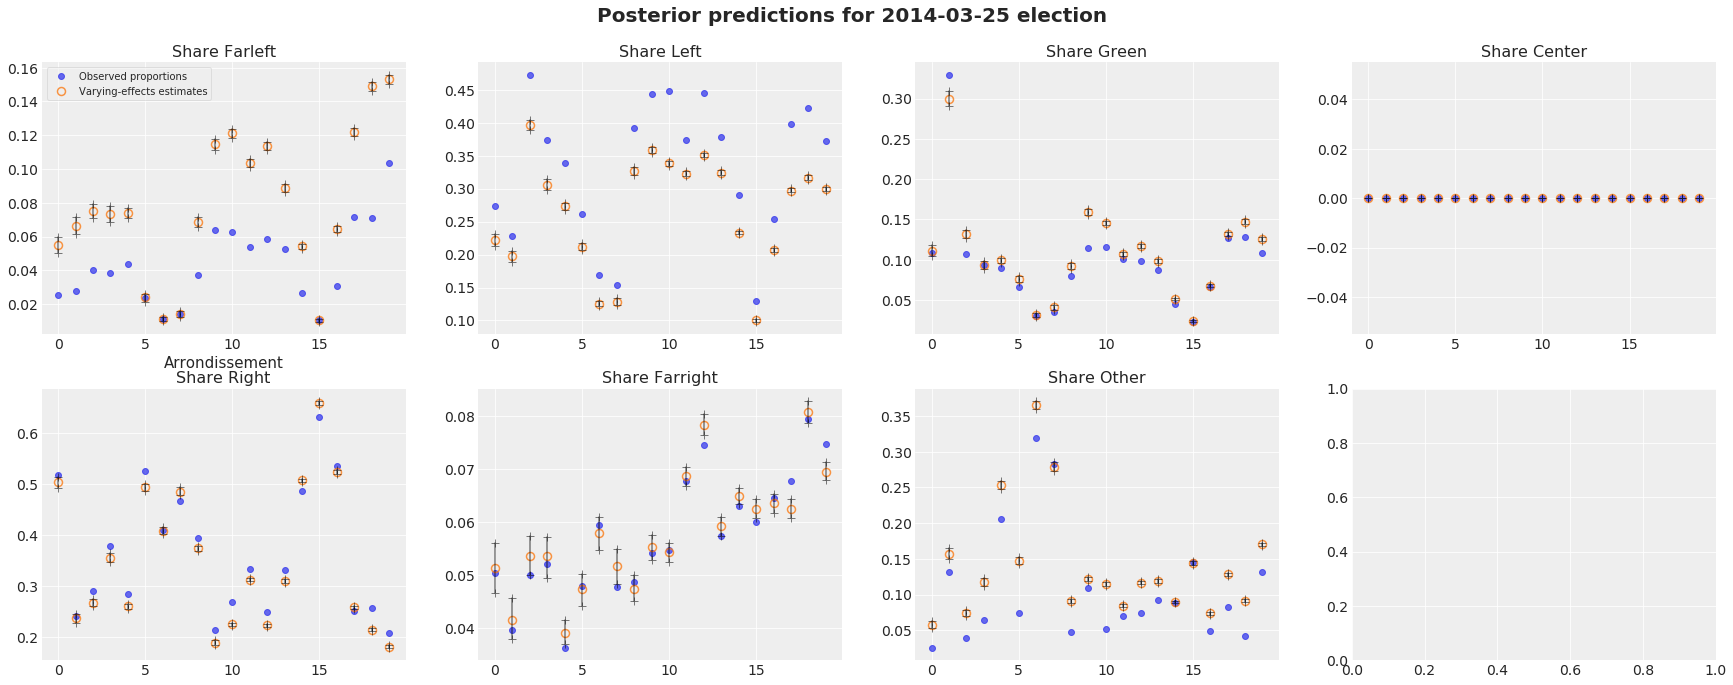

In [239]:
election = "2014-03-25"
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
i = 0
for line in axes:
    for col in line:
        try:
            col.plot(
                np.arange(Ndistricts),
                d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
                "o",
                ms=6,
                alpha=0.7,
                label="Observed proportions",
            )
            col.plot(
                np.arange(Ndistricts),
                share_mean[election_mask, i],
                "o",
                fillstyle="none",
                ms=8,
                markeredgewidth=1.5,
                alpha=0.8,
                label="Varying-effects estimates",
            )
            col.plot(
                [np.arange(Ndistricts), np.arange(Ndistricts)],
                az.hpd(share_est[:, election_mask, i]).T,
                "k-+",
                ms=8,
                alpha=0.5,
            )
            col.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
            col.set_title(f"Share {PARTIES[i].title()}")
            if i == 0:
                col.set_xlabel("Arrondissement")
                col.legend(frameon=True, framealpha=0.5, fontsize=10)
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Posterior predictions for {election} election", y=0.95, size=20, weight="bold",
)